# Modeling - Panel Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from linearmodels.panel import PanelOLS
import os
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from linearmodels.panel import PanelOLS
import pickle
from sklearn.preprocessing import StandardScaler

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

In [2]:
df_train = pd.read_pickle("feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle("feature_engineering_validation_dataset.pkl")

In [3]:
display(df_train.head(3))
print("Shape: ", df_train.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-01-12,10001,27.626437,29.695810,2.245193,61.460460,59.611104,28.867446,45.176114,37.305956,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-13,10001,29.008665,26.041461,2.355360,64.432266,56.863993,29.842478,45.557870,39.091765,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-14,10001,29.180034,26.490986,1.905282,68.381496,64.845904,34.533212,47.707745,37.870228,...,0,0,0,0,0,0,0,0,0,0


Shape:  (8038, 105)


In [4]:
display(df_valid.head(3))
print("Shape: ", df_valid.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-02-02,10001,32.242002,16.735176,3.854930,65.747872,67.494766,22.045415,66.438259,44.750377,...,0,0,0,0,0,0,0,0,0,0
1,2021-02-03,10001,34.991057,18.797872,9.298927,66.752089,64.805847,26.106294,63.255370,46.075447,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-04,10001,31.996321,17.816678,8.826546,69.706913,64.414916,26.765270,63.628774,46.781418,...,0,0,0,0,0,0,0,0,0,0


Shape:  (1717, 105)


In [5]:
# Feature Selection: 
# Drop smoothed_wvaccine_likely_who since we already have smoothed_wvaccine_likely_govt_health
# Drop smoothed_wwearing_mask since we already have smoothed_wothers_masked
# Drop smoothed_wcovid_vaccinated_or_accept since it states that espondents who either have already received a COVID vaccine or would definitely or probably choose to get vaccinated
# Drop entity level columns since we run the PanelOLS

In [6]:
list_drop_cols = ['smoothed_wvaccine_likely_who','smoothed_wwearing_mask','smoothed_wcovid_vaccinated_or_accept'
                  ,'smoothed_wvaccine_likely_who_rolling_mean_3','smoothed_wwearing_mask_rolling_mean_3','smoothed_wcovid_vaccinated_or_accept_rolling_mean_3'
                  ,'smoothed_wvaccine_likely_who_lag_3','smoothed_wwearing_mask_lag_3','smoothed_wcovid_vaccinated_or_accept_lag_3',
                  'dummy_delaware',
                  'dummy_district_of_columbia',
                  'dummy_florida',
                  'dummy_georgia',
                  'dummy_idaho',
                  'dummy_illinois',
                  'dummy_indiana',
                  'dummy_iowa',
                  'dummy_kansas',
                  'dummy_kentucky',
                  'dummy_louisiana',
                  'dummy_maine',
                  'dummy_maryland',
                  'dummy_massachusetts',
                  'dummy_michigan',
                  'dummy_minnesota',
                  'dummy_mississippi',
                  'dummy_missouri',
                  'dummy_montana',
                  'dummy_nebraska',
                  'dummy_nevada',
                  'dummy_new_hampshire',
                  'dummy_new_jersey',
                  'dummy_new_mexico',
                  'dummy_new_york',
                  'dummy_north_carolina',
                  'dummy_north_dakota',
                  'dummy_ohio',
                  'dummy_oklahoma',
                  'dummy_oregon',
                  'dummy_pennsylvania',
                  'dummy_rhode_island',
                  'dummy_south_carolina',
                  'dummy_south_dakota',
                  'dummy_tennessee',
                  'dummy_texas',
                  'dummy_utah',
                  'dummy_vermont',
                  'dummy_virginia',
                  'dummy_washington',
                  'dummy_west_virginia',
                  'dummy_wisconsin',
                  'dummy_wyoming']

In [7]:
df_train = df_train.drop(columns = list_drop_cols)
df_valid = df_valid.drop(columns = list_drop_cols)

In [8]:
print("Shape: ", df_train.shape)
print("Shape: ", df_valid.shape)

Shape:  (8038, 53)
Shape:  (1717, 53)


In [9]:
target_var = 'smoothed_wcovid_vaccinated'
list_features = [col for col in df_train.columns if col not in ["time_value",'geo_value','state','county_name'
                                                                ,'day_of_week','day','week_of_month',target_var]]

In [10]:
list_scale = [col for col in list_features if 'dummy' not in col]
list_scale[-5:]

['smoothed_wcli_lag_3_x_smoothed_wwork_outside_home_1d',
 'smoothed_wothers_masked_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wtested_14d_x_smoothed_wvaccine_likely_govt_health',
 'smoothed_wcli_x_smoothed_wcovid_vaccinated_or_accept',
 'smoothed_wcovid_vaccinated_or_accept_x_smoothed_wvaccine_likely_friends']

In [13]:
display(df_train.head(3))
display(df_valid.head(3))

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,...,smoothed_wvaccine_likely_politicians_rolling_mean_3,smoothed_wlarge_event_1d_rolling_mean_3,smoothed_wworried_become_ill_x_smoothed_wwork_outside_home_1d,smoothed_wworried_become_ill_x_smoothed_wspent_time_1d,smoothed_wcli_lag_3_x_smoothed_wwork_outside_home_1d,smoothed_wothers_masked_x_smoothed_wcovid_vaccinated_or_accept,smoothed_wtested_14d_x_smoothed_wvaccine_likely_govt_health,smoothed_wcli_x_smoothed_wcovid_vaccinated_or_accept,smoothed_wcovid_vaccinated_or_accept_x_smoothed_wvaccine_likely_friends,dummy_weekend
0,2021-01-12,10001,27.626437,29.695810,2.245193,59.611104,28.867446,45.176114,37.305956,95.834318,...,13.096410,7.750914,22.238492,16.468424,0.606301,58.900212,8.572422,0.684904,19.700484,0
1,2021-01-13,10001,29.008665,26.041461,2.355360,56.863993,29.842478,45.557870,39.091765,95.389735,...,13.925718,6.675872,22.229138,16.495485,0.540161,61.461767,7.771417,0.845417,22.484168,0
2,2021-01-14,10001,29.180034,26.490986,1.905282,64.845904,34.533212,47.707745,37.870228,96.490757,...,15.048809,5.862543,24.557292,18.922057,0.442640,65.981823,9.148188,0.620658,25.046643,0


,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,...,smoothed_wvaccine_likely_politicians_rolling_mean_3,smoothed_wlarge_event_1d_rolling_mean_3,smoothed_wworried_become_ill_x_smoothed_wwork_outside_home_1d,smoothed_wworried_become_ill_x_smoothed_wspent_time_1d,smoothed_wcli_lag_3_x_smoothed_wwork_outside_home_1d,smoothed_wothers_masked_x_smoothed_wcovid_vaccinated_or_accept,smoothed_wtested_14d_x_smoothed_wvaccine_likely_govt_health,smoothed_wcli_x_smoothed_wcovid_vaccinated_or_accept,smoothed_wcovid_vaccinated_or_accept_x_smoothed_wvaccine_likely_friends,dummy_weekend
0,2021-02-02,10001,32.242002,16.735176,3.854930,67.494766,22.045415,66.438259,44.750377,92.433983,...,7.254562,10.976945,30.204162,21.761664,0.111862,60.773376,3.689339,0.182196,18.255616,0
1,2021-02-03,10001,34.991057,18.797872,9.298927,64.805847,26.106294,63.255370,46.075447,87.193901,...,5.985934,10.666794,29.859584,22.676251,0.117389,58.203751,4.907428,0.183158,22.684308,0
2,2021-02-04,10001,31.996321,17.816678,8.826546,64.414916,26.765270,63.628774,46.781418,86.907612,...,5.063887,9.678267,30.134211,20.610403,0.122211,60.580613,4.768682,0.000000,24.967046,0


In [14]:
list_all_faeture = list_features.copy()
list_all_faeture.append("constant")
df_train['constant'] = 1.0
df_valid['constant'] = 1.0

In [15]:
model = PanelOLS(dependent=df_train.set_index(['geo_value', 'time_value'])[target_var],
                 exog=df_train.set_index(['geo_value', 'time_value'])[list_all_faeture],
                 entity_effects=True,
                 time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

In [16]:
res.summary

Dep. Variable:,smoothed_wcovid_vaccinated,R-squared:,0.8792
Estimator:,PanelOLS,R-squared (Between):,0.9482
No. Observations:,8038,R-squared (Within):,0.8792
Date:,"Wed, Apr 23 2025",R-squared (Overall):,0.9107
Time:,04:33:33,Log-likelihood,-1.226e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1170.0
Entities:,437,P-value,0.0000
Avg Obs:,18.394,Distribution:,"F(47,7554)"
Min Obs:,16.000,,
Max Obs:,20.000,F-statistic (robust):,846.88


In [17]:
with open('PanelRegression_Experiment_02.pkl', 'wb') as f:
    pickle.dump(res, f)

In [18]:
train_preds = res.predict(df_train.set_index(['geo_value', 'time_value'])[list_all_faeture])
display(train_preds.head(5))
print("Shape :", train_preds.shape)

predictions
geo_value time_value             
10001     2021-01-12     5.678475
          2021-01-13     5.363576
          2021-01-14     5.434102
          2021-01-15     5.445145
          2021-01-16     5.770844

Shape : (8038, 1)


In [19]:
aligned_y_train = df_train.set_index(['geo_value', 'time_value']).loc[train_preds.index][[target_var]]
display(aligned_y_train.head(5))
print("Shape :", aligned_y_train.shape)

smoothed_wcovid_vaccinated
geo_value time_value                            
10001     2021-01-12                    4.789884
          2021-01-13                    5.048679
          2021-01-14                    5.813447
          2021-01-15                    5.937796
          2021-01-16                    6.138341

Shape : (8038, 1)


In [20]:
train_rmse = root_mean_squared_error(aligned_y_train, train_preds)
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 1.2964


In [21]:
valid_preds = res.predict(df_valid.set_index(['geo_value', 'time_value'])[list_all_faeture])
display(valid_preds.head(10))
print("Shape :", valid_preds.shape)

predictions
geo_value time_value             
10001     2021-02-02    21.466216
          2021-02-03    19.416800
          2021-02-04    18.305877
          2021-02-05    20.056567
10003     2021-02-02    17.202265
          2021-02-03    18.795269
          2021-02-04    20.274904
          2021-02-05    20.370027
10005     2021-02-02    17.729180
          2021-02-03    17.083201

Shape : (1717, 1)


In [22]:
aligned_y_val = df_valid.set_index(['geo_value', 'time_value']).loc[valid_preds.index][[target_var]]
display(aligned_y_val.head(10))
print("Shape :", aligned_y_val.shape)

smoothed_wcovid_vaccinated
geo_value time_value                            
10001     2021-02-02                   19.062903
          2021-02-03                   19.254920
          2021-02-04                   20.664035
          2021-02-05                   20.781314
10003     2021-02-02                   19.466377
          2021-02-03                   19.745641
          2021-02-04                   20.648415
          2021-02-05                   19.294905
10005     2021-02-02                   16.050787
          2021-02-03                   16.714988

Shape : (1717, 1)


In [23]:
rmse = root_mean_squared_error(aligned_y_val, valid_preds)
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 1.6201


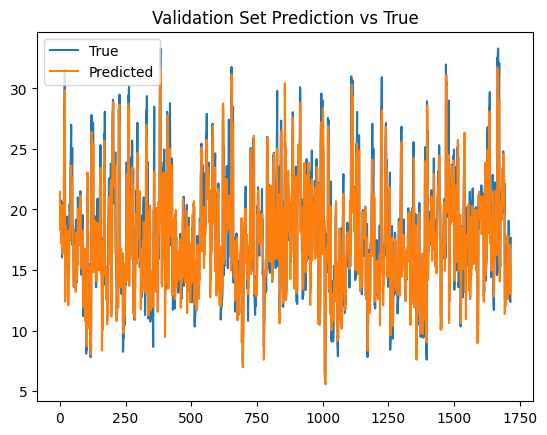

In [24]:
import matplotlib.pyplot as plt

plt.plot(aligned_y_val['smoothed_wcovid_vaccinated'].values, label="True")
plt.plot(valid_preds['predictions'].values, label="Predicted")
plt.title("Validation Set Prediction vs True")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Residual Distribution')

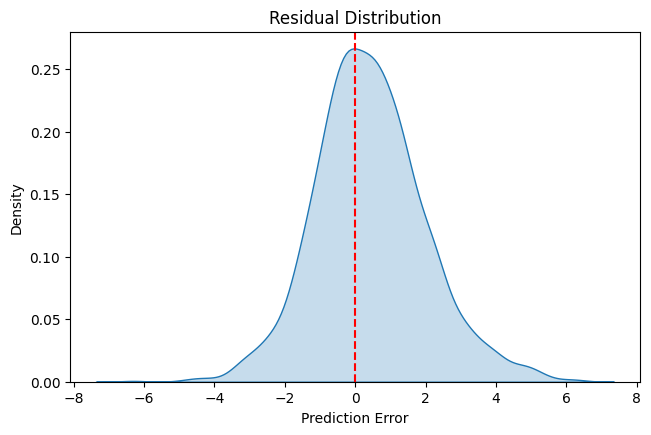

In [25]:
plt.figure(figsize=(25, 10))
plt.subplot(234)
sns.kdeplot(aligned_y_val['smoothed_wcovid_vaccinated'].values - valid_preds['predictions'].values, 
            label='Residual', fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Residual Distribution')